In [1]:
import pandas as pd
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, avg
import matplotlib.pyplot as plt

Create Spark Session

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 - Random Forest")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')
    .config('spark.executor.memory', '8g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/20 12:07:40 WARN Utils: Your hostname, LAPTOP-RELH58H1 resolves to a loopback address: 127.0.1.1; using 172.19.22.4 instead (on interface eth0)
23/08/20 12:07:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/20 12:07:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Load Data

In [3]:
SVM_predictions = spark.read.parquet(f'../data/curated/SVM_predictions.parquet/*')
LinearRegression_predictions = spark.read.parquet(f'../data/curated/LinearRegression_predictions.parquet/*')

In [4]:
# Calculate the average number of trips and predicted number of trips for each hour
hourly_avg_actual = SVM_predictions.groupBy("Hour_encoded").agg(avg("number_of_trips").alias("avg_actual"))
SVM_hourly_avg_predicted = SVM_predictions.groupBy("Hour_encoded").agg(avg("prediction").alias("avg_predicted"))
LinearRegression_hourly_avg_predicted = LinearRegression_predictions.groupBy("Hour_encoded").agg(avg("prediction").alias("avg_predicted"))


# Convert to Pandas DataFrames
hourly_avg_actual_pd = hourly_avg_actual.toPandas()
SVM_hourly_avg_predicted_pd = SVM_hourly_avg_predicted.toPandas()
LinearRegression_hourly_avg_predicted_pd = LinearRegression_hourly_avg_predicted.toPandas()


In [5]:
def decode_sparse_vector(encoded_hour):
    if encoded_hour.numNonzeros() == 0:
        return "23"
    nonzero_index = encoded_hour.indices[0]
    return str(nonzero_index)

hourly_avg_actual_pd["Hour"] = hourly_avg_actual_pd["Hour_encoded"].apply(decode_sparse_vector)
SVM_hourly_avg_predicted_pd["Hour"] = SVM_hourly_avg_predicted_pd["Hour_encoded"].apply(decode_sparse_vector)
LinearRegression_hourly_avg_predicted_pd["Hour"] = LinearRegression_hourly_avg_predicted_pd["Hour_encoded"].apply(decode_sparse_vector)

# Convert "Hour" column to integer type for sorting
hourly_avg_actual_pd["Hour"] = hourly_avg_actual_pd["Hour"].astype(int)
SVM_hourly_avg_predicted_pd["Hour"] = SVM_hourly_avg_predicted_pd["Hour"].astype(int)
LinearRegression_hourly_avg_predicted_pd["Hour"] = LinearRegression_hourly_avg_predicted_pd["Hour"].astype(int)

# Sort the DataFrames by "Hour" column
hourly_avg_actual_pd = hourly_avg_actual_pd.sort_values(by="Hour")
SVM_hourly_avg_predicted_pd = SVM_hourly_avg_predicted_pd.sort_values(by="Hour")
LinearRegression_hourly_avg_predicted_pd = LinearRegression_hourly_avg_predicted_pd.sort_values(by="Hour")


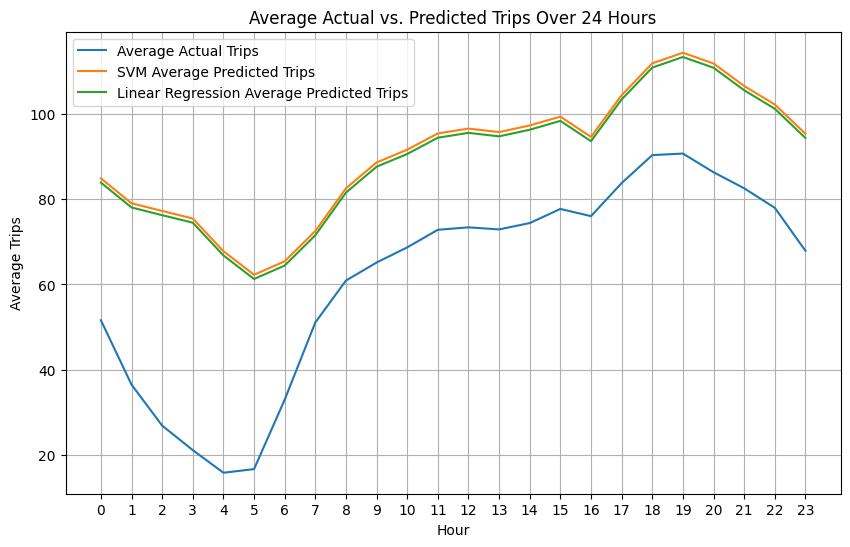

In [6]:
plt.figure(figsize=(10, 6))

# Adding a small offset to the second dataset
offset = 1  # Adjust this value as needed
plt.plot(hourly_avg_actual_pd["Hour"], hourly_avg_actual_pd["avg_actual"], label="Average Actual Trips")
plt.plot(SVM_hourly_avg_predicted_pd["Hour"], SVM_hourly_avg_predicted_pd["avg_predicted"] + offset, label="SVM Average Predicted Trips")
plt.plot(LinearRegression_hourly_avg_predicted_pd["Hour"], LinearRegression_hourly_avg_predicted_pd["avg_predicted"], label="Linear Regression Average Predicted Trips")
plt.xlabel("Hour")
plt.ylabel("Average Trips")
plt.title("Average Actual vs. Predicted Trips Over 24 Hours")
plt.legend()
plt.xticks(range(24))
plt.grid(True)

# Save the plot as an image
plt.savefig("../plots/Model_Results_plot.png")

plt.show()
